In [1]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

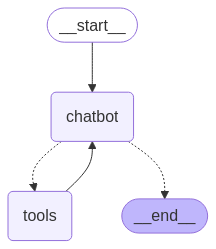

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [3]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to request expert assistance for you regarding building an AI agent. I'll use the human_assistance function to get this guidance for you. Let me do that now.", 'type': 'text'}, {'id': 'toolu_01TPwZaLW1fe6SD1c6hBakuG', 'input': {'query': 'A user is seeking expert guidance for building an AI agent. Could you please provide some key points or advice on the process of building an AI agent?'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01TPwZaLW1fe6SD1c6hBakuG)
 Call ID: toolu_01TPwZaLW1fe6SD1c6hBakuG
  Args:
    query: A user is seeking expert guidance for building an AI agent. Could you please provide some key points or advice on the process of building an AI a

In [4]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [5]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to request expert assistance for you regarding building an AI agent. I'll use the human_assistance function to get this guidance for you. Let me do that now.", 'type': 'text'}, {'id': 'toolu_01TPwZaLW1fe6SD1c6hBakuG', 'input': {'query': 'A user is seeking expert guidance for building an AI agent. Could you please provide some key points or advice on the process of building an AI agent?'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01TPwZaLW1fe6SD1c6hBakuG)
 Call ID: toolu_01TPwZaLW1fe6SD1c6hBakuG
  Args:
    query: A user is seeking expert guidance for building an AI agent. Could you please provide some key points or advice on the process of building an AI agent?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out